In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, BertModel
from torchvision.models import ResNet50_Weights, resnet50
from sklearn.metrics import accuracy_score, classification_report, f1_score, top_k_accuracy_score
from tqdm import tqdm

# --- Configuration ---
DATASET_NAME = "flaviagiammarino/vqa-rad"
SPLITS_PATH = Path("vqarad_full_splits.json")
SEED = 42

# IMPROVEMENT: Use 100% of data (Original was 0.05)
SUBSET_FRAC = 1.0
VAL_FRAC = 0.10
TEST_FRAC = 0.10

EPOCHS = 15
BATCH_SIZE = 8
LR = 2e-5
MAX_QUESTION_LEN = 64

# --- Missing Functions: Seed & Device ---
def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device():
    """Returns the available device."""
    return "cuda" if torch.cuda.is_available() else "cpu"

# Initialize
set_seed(SEED)
device = get_device()
print(f"Running on {device} with {SUBSET_FRAC*100}% of data.")

Running on cuda with 100.0% of data.


In [ ]:
def normalize_text(s: str) -> str:
    return " ".join(s.lower().strip().split())

def load_or_create_subset_splits(dataset_name, subset_frac, seed, val_frac, test_frac, path, force_regen=False):
    print(f"Loading {dataset_name}...")
    ds = load_dataset(dataset_name, split="train").shuffle(seed=seed)
    subset_size = int(len(ds) * subset_frac)

    cfg = {"subset_frac": subset_frac, "seed": seed, "subset_size": subset_size}

    def make_indices():
        perm = np.random.RandomState(seed).permutation(subset_size).tolist()
        n_val = int(subset_size * val_frac)
        n_test = int(subset_size * test_frac)
        n_train = subset_size - n_val - n_test
        return {"train": perm[:n_train], "val": perm[n_train:n_train+n_val], "test": perm[n_train+n_val:]}

    if path.exists() and not force_regen:
        try:
            cached = json.loads(path.read_text())
            if cached.get("config") == cfg:
                indices = cached["indices"]
            else:
                indices = make_indices()
                path.write_text(json.dumps({"config": cfg, "indices": indices}))
        except:
            indices = make_indices()
    else:
        indices = make_indices()
        path.write_text(json.dumps({"config": cfg, "indices": indices}))

    return ds.select(indices["train"]), ds.select(indices["val"]), ds.select(indices["test"])

# Load Data & Build Vocab
train_ds, val_ds, test_ds = load_or_create_subset_splits(
    DATASET_NAME, subset_frac=SUBSET_FRAC, seed=SEED,
    val_frac=VAL_FRAC, test_frac=TEST_FRAC, path=SPLITS_PATH
)

def build_answer_vocab(train_ds):
    answers = [normalize_text(a) for a in train_ds["answer"]]
    uniq = sorted(set(answers))
    answer_to_id = {a: i for i, a in enumerate(uniq)}
    if "<unk>" not in answer_to_id:
        answer_to_id["<unk>"] = len(answer_to_id)
    id_to_answer = {i: a for a, i in answer_to_id.items()}
    return answer_to_id, id_to_answer

answer_to_id, id_to_answer = build_answer_vocab(train_ds)
print(f"Vocab size: {len(answer_to_id)}")

Loading flaviagiammarino/vqa-rad...
Vocab size: 384


In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V2
image_transform = weights.transforms()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class VqaRadDataset(Dataset):
    def __init__(self, dataset, tokenizer, image_transform, answer_to_id):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.answer_to_id = answer_to_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        pixel_values = self.image_transform(image)
        question = normalize_text(item["question"])
        encoding = self.tokenizer(
            question, padding="max_length", truncation=True,
            max_length=MAX_QUESTION_LEN, return_tensors="pt"
        )
        ans_text = normalize_text(item["answer"])
        label = self.answer_to_id.get(ans_text, self.answer_to_id["<unk>"])
        return {
            "pixel_values": pixel_values,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

train_loader = DataLoader(VqaRadDataset(train_ds, tokenizer, image_transform, answer_to_id),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(VqaRadDataset(val_ds, tokenizer, image_transform, answer_to_id),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(VqaRadDataset(test_ds, tokenizer, image_transform, answer_to_id),
                         batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class ImprovedResNetBertVQA(nn.Module):
    def __init__(self, num_answers, hidden_dim=512, dropout=0.3):
        super().__init__()
        # Image
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.img_enc = nn.Sequential(*list(resnet.children())[:-1])
        # Text
        self.txt_enc = BertModel.from_pretrained("bert-base-uncased")
        # Projections
        self.img_proj = nn.Linear(2048, hidden_dim)
        self.txt_proj = nn.Linear(768, hidden_dim)
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_answers)
        )

    def forward(self, pixel_values, input_ids, mask):
        img = self.img_proj(self.img_enc(pixel_values).flatten(1))
        txt = self.txt_proj(self.txt_enc(input_ids, mask).last_hidden_state[:, 0, :])
        # Optimization: Element-wise multiplication
        return self.classifier(img * txt)

In [ ]:
def train_model_with_history():
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_path = "best_model_optimized.pth"

    # HISTORY STORAGE
    history = {
        "train_loss": [],
        "val_acc": []
    }

    print(f"Starting Training for {EPOCHS} epochs...")
    for epoch in range(1, EPOCHS+1):
        # --- TRAINING ---
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
            for k, v in batch.items(): batch[k] = v.to(device)
            optimizer.zero_grad()
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            loss = criterion(logits, batch["label"])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        scheduler.step()

        # --- VALIDATION ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                for k, v in batch.items(): batch[k] = v.to(device)
                logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
                preds = logits.argmax(dim=1)
                correct += (preds == batch["label"]).sum().item()
                total += batch["label"].size(0)

        val_acc = correct / total
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_path)

    return best_path, history

# Run training and get history
best_model_file, history = train_model_with_history()

Starting Training for 15 epochs...


Epoch 1: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]


Epoch 1 | Loss: 4.7558 | Val Acc: 0.2793


Epoch 2: 100%|██████████| 180/180 [00:53<00:00,  3.40it/s]


Epoch 2 | Loss: 3.3625 | Val Acc: 0.3017


Epoch 3: 100%|██████████| 180/180 [00:50<00:00,  3.54it/s]


Epoch 3 | Loss: 3.2230 | Val Acc: 0.2905


Epoch 4: 100%|██████████| 180/180 [00:52<00:00,  3.41it/s]


Epoch 4 | Loss: 3.1456 | Val Acc: 0.3352


Epoch 5: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]


Epoch 5 | Loss: 3.0408 | Val Acc: 0.3128


Epoch 6: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]


Epoch 6 | Loss: 2.8754 | Val Acc: 0.3743


Epoch 7: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s]


Epoch 7 | Loss: 2.7791 | Val Acc: 0.4190


Epoch 8: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]


Epoch 8 | Loss: 2.6625 | Val Acc: 0.4413


Epoch 9: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Epoch 9 | Loss: 2.5886 | Val Acc: 0.4078


Epoch 10: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]


Epoch 10 | Loss: 2.4931 | Val Acc: 0.4302


Epoch 11: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Epoch 11 | Loss: 2.4357 | Val Acc: 0.4134


Epoch 12: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Epoch 12 | Loss: 2.3906 | Val Acc: 0.4246


Epoch 13: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]


Epoch 13 | Loss: 2.3737 | Val Acc: 0.4134


Epoch 14: 100%|██████████| 180/180 [00:50<00:00,  3.57it/s]


Epoch 14 | Loss: 2.3683 | Val Acc: 0.4190


Epoch 15: 100%|██████████| 180/180 [00:50<00:00,  3.58it/s]


Epoch 15 | Loss: 2.3436 | Val Acc: 0.4190


In [ ]:
def evaluate_metrics(model_path):
    print("\n--- Final Evaluation ---")
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id))
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for batch in test_loader:
            for k, v in batch.items(): batch[k] = v.to(device)
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    # 1. Standard Accuracy
    acc = accuracy_score(all_labels, all_preds)

    # 2. Weighted F1 Score (Good for imbalanced data)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # 3. Top-5 Accuracy
    # (Checks if the correct answer is in the top 5 predicted probabilities)
    # We filter out classes that don't exist in the test set for fair evaluation if using scikit-learn strict
    # But usually top_k_accuracy_score handles full logits
    try:
        top5 = top_k_accuracy_score(all_labels, np.array(all_logits), k=5, labels=range(len(answer_to_id)))
    except:
        top5 = 0.0 # Fallback if k > n_classes

    print(f"Accuracy:        {acc:.4f}")
    print(f"Weighted F1:     {f1:.4f}")
    print(f"Top-5 Accuracy:  {top5:.4f}")

    # 4. Detailed Report (Precision/Recall per class)
    # Only showing classes that actually appeared in the test set to keep it readable
    present_indices = sorted(list(set(all_labels) | set(all_preds)))
    present_names = [id_to_answer[i] for i in present_indices]

    print("\n--- Detailed Classification Report ---")
    print(classification_report(all_labels, all_preds, labels=present_indices, target_names=present_names, zero_division=0))

evaluate_metrics(best_model_file)


--- Final Evaluation ---
Accuracy:        0.4302
Weighted F1:     0.4104
Top-5 Accuracy:  0.6034

--- Detailed Classification Report ---
                                                        precision    recall  f1-score   support

                                                  5 cm       0.00      0.00      0.00         1
                  5.6cm focal, predominantly hypodense       0.04      1.00      0.07         1
                                               abscess       0.00      0.00      0.00         2
                                                   air       0.00      0.00      0.00         1
                                                 axial       0.57      1.00      0.73         4
                                         basal ganglia       0.00      0.00      0.00         1
                                            cerebellum       0.00      0.00      0.00         1
                                           chest x-ray       0.00      0.00      0.00        

In [ ]:
def evaluate_open_closed_inferred(model_path):
    print("\n--- Open vs. Closed Question Evaluation ---")

    # 1. Load Model
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id))
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # 2. Get all predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            for k, v in batch.items(): batch[k] = v.to(device)
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())

    # 3. Infer Question Types (Since 'answer_type' column is missing)
    # Convention: If the ground truth answer is "yes" or "no", it's Closed-Ended.
    # We use the raw text from test_ds to determine this.
    raw_answers = [normalize_text(a) for a in test_ds["answer"]]

    closed_indices = []
    open_indices = []

    for i, ans in enumerate(raw_answers):
        if ans in ["yes", "no"]:
            closed_indices.append(i)
        else:
            open_indices.append(i)

    print(f"\nInferred {len(closed_indices)} Closed (Yes/No) and {len(open_indices)} Open questions.")

    # 4. Helper to calculate accuracy for a subset
    def calc_subset_acc(indices, name):
        if not indices:
            print(f"{name} Accuracy: N/A (0 samples)")
            return

        subset_preds = [all_preds[i] for i in indices]
        subset_labels = [all_labels[i] for i in indices]

        acc = accuracy_score(subset_labels, subset_preds)
        print(f"{name} Accuracy: {acc:.4f} ({len(indices)} samples)")

    # 5. Print Results
    calc_subset_acc(closed_indices, "Closed-Ended (Binary)")
    calc_subset_acc(open_indices, "Open-Ended (Free text)")

    # Overall
    total_acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {total_acc:.4f}")

# Run the split evaluation
evaluate_open_closed_inferred(best_model_file)


--- Open vs. Closed Question Evaluation ---


Predicting: 100%|██████████| 23/23 [00:02<00:00,  7.99it/s]



Inferred 101 Closed (Yes/No) and 78 Open questions.
Closed-Ended (Binary) Accuracy: 0.7228 (101 samples)
Open-Ended (Free text) Accuracy: 0.0641 (78 samples)

Overall Accuracy: 0.4358


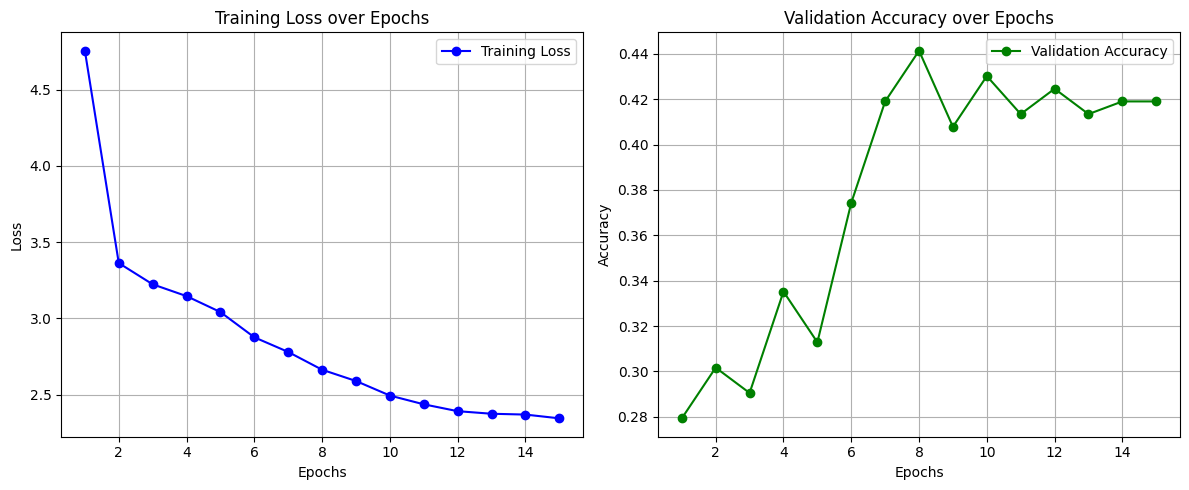

In [ ]:
def plot_evaluation_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-o', label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate plots
plot_evaluation_curves(history)